In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import os
import random

import pandas as pd
import seaborn as sns

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D, Dropout, SpatialDropout2D, BatchNormalization,Dense, Flatten
from tensorflow.keras.layers import ELU
from keras.optimizers import Adam

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils import class_weight

import numpy as np

In [2]:
path = "/kaggle/input/face-detection-dataset"
train_img_path = "/kaggle/input/face-detection-dataset/images/train"
val_img_path = "/kaggle/input/face-detection-dataset/images/val"

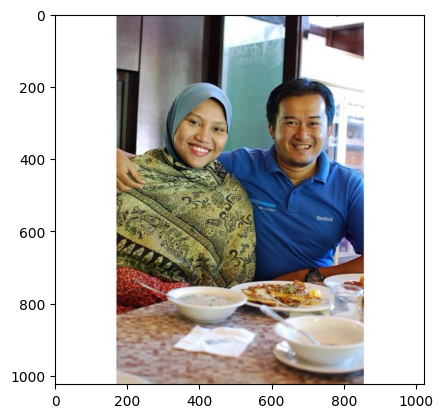

In [3]:
img = cv2.cvtColor(cv2.imread('/kaggle/input/face-detection-dataset/images/train/00006c07d2b033d1.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [4]:
# open text data
label= open("/kaggle/input/face-detection-dataset/labels2/00006c07d2b033d1.txt", "r")

# show content 
for row in label:
    print(row.strip())  # strip() entfernt überflüssige Leerzeichen und Zeilenumbrüche

# close text data
label.close()

Human face 332.8 235.199488 475.200512 432.0
Human face 609.599488 227.2 755.2 420.799488


In [30]:
# open text data
label = open("/kaggle/input/face-detection-dataset/labels/train/00006c07d2b033d1.txt", "r")

# show content 
for row in label:
    print(row.strip())  # strip() entfernt überflüssige Leerzeichen und Zeilenumbrüche

# close text data
label.close()

0 0.3943359375 0.325390125 0.139063 0.192188
0 0.6656245 0.315625 0.1421880000000001 0.189062


[['332.8', '235.199488', '475.200512', '432.0'], ['609.599488', '227.2', '755.2', '420.799488']]


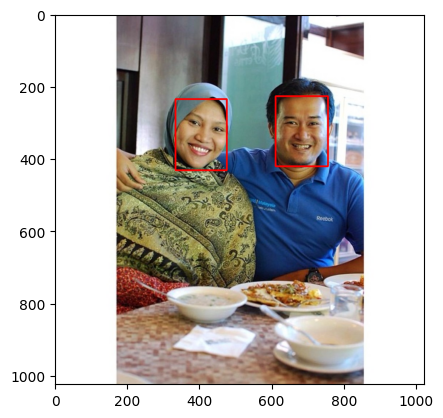

In [46]:
import re

img = cv2.cvtColor(cv2.imread('/kaggle/input/face-detection-dataset/images/train/00006c07d2b033d1.jpg'), cv2.COLOR_BGR2RGB)

bb_coor = []
with open('/kaggle/input/face-detection-dataset/labels2/00006c07d2b033d1.txt', 'r') as data:
    for row in data:
        float_numbers = re.findall(r'\d+\.\d+', row)
        bb_coor.append(float_numbers)

print(bb_coor)

for i in range(0, len(bb_coor)):
    cv2.rectangle(img, (round(float(bb_coor[i][0])), 
                        round(float(bb_coor[i][1]))),
                  (round(float(bb_coor[i][2])),
                   round(float(bb_coor[i][3]))), (255, 0, 0), 3)

plt.imshow(img)

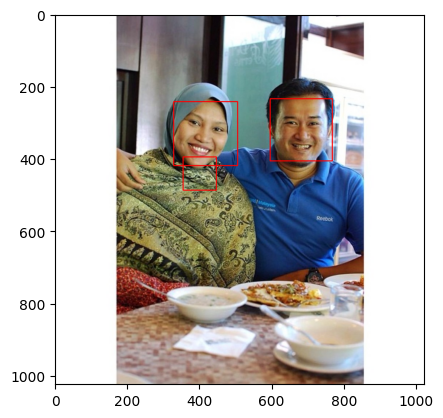

In [47]:
img = cv2.cvtColor(cv2.imread('/kaggle/input/face-detection-dataset/images/train/00006c07d2b033d1.jpg'), cv2.COLOR_BGR2RGB)

# Face detection with haarcascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +
                                    'haarcascade_frontalface_default.xml')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
plt.imshow(img)

In [3]:
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

--2024-09-10 10:38:00--  https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: 'coco.names'

coco.names          100%[===================>]     625  --.-KB/s    in 0s      

2024-09-10 10:38:01 (15.5 MB/s) - 'coco.names' saved [625/625]



In [5]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

--2024-09-10 10:38:37--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: 'yolov3.weights'

yolov3.weights      100%[===================>] 236.52M  6.06MB/s    in 42s     

2024-09-10 10:39:24 (5.62 MB/s) - 'yolov3.weights' saved [248007048/248007048]

--2024-09-10 10:39:25--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: 'yolov3.cfg'

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2

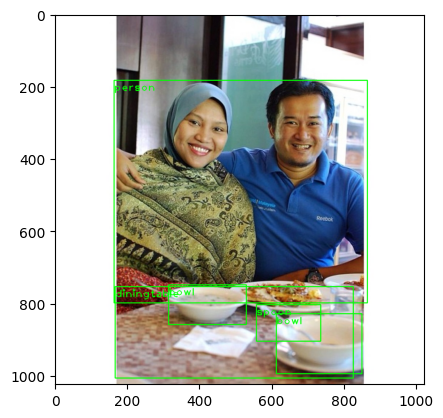

In [8]:
# load YOLO-model
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
classes = []
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# load and prepare the image
img = cv2.cvtColor(cv2.imread('/kaggle/input/face-detection-dataset/images/train/00006c07d2b033d1.jpg'), cv2.COLOR_BGR2RGB)
height, width, channels = img.shape

# prepare image for YOLO
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

# object recognition
net.setInput(blob)
outs = net.forward(output_layers)

# show informations
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # object recognized
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# make Non-maximum suppression 
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# show results
font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = (0, 255, 0)  # Grün
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y + 30), font, 2, color, 2)

plt.imshow(img)